In [2]:
## Structural Estimation Problem Set 2 - GB Family and MLE
## by Alejandro Parraguez

import numpy as np

import scipy.stats as sts
from scipy import special
import scipy.optimize as opt

import matplotlib.pyplot as plt

import pandas as pd
from pandas import DataFrame, Series

In [3]:
hcc = np.loadtxt('/Users/ale/Desktop/MAPSS/Winter/StructuralEstimation/PSet_2/clms.txt')

In [4]:
hcc

array([ 361.65,  123.04,  541.77, ...,   97.43,  186.88,  119.19])

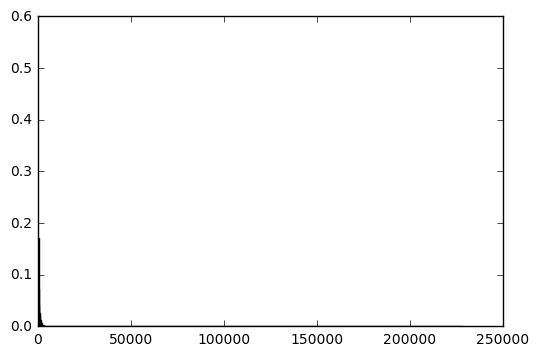

1.0


In [5]:
# Histogram Parameters

wght = (1/hcc.shape[0])*np.ones_like(hcc)

# Histogram all data

n, bin_cuts, patches = plt.hist(hcc,1000, weights = wght)
plt.show()
print(n.sum())

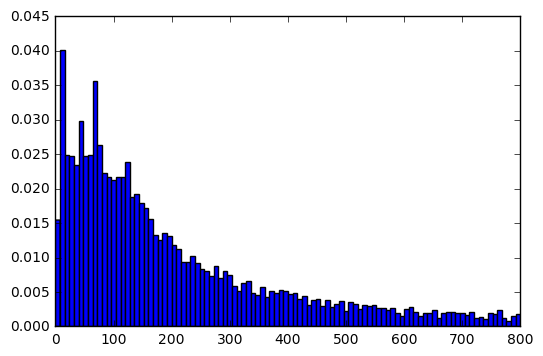

0.849420849421


In [6]:
# Histogram only less than 800

n, bin_cuts, patches = plt.hist(hcc,100, weights = wght,range=(0, 800))
plt.show()
print(n.sum())

In [7]:
# (b) - MLE GA

# Initial Parameters 

def alphbet(df):

    exp = df.mean()
    var = df.var()
    
    beta_init = var/exp
    alph_init = exp/beta_init
    
    return alph_init, beta_init

aGA_0,bGA_0 = alphbet(hcc)


In [8]:
aGA_0,bGA_0

(0.032872796694206986, 21911.064702753894)

In [9]:
# Define the Log-Likelihood Function - Gamma

def log_lik_GA(xvect,alpha,beta):
    pdf_vect = sts.gamma.pdf(xvect,alpha,scale=beta)
    ln_pdf_vect = np.log(pdf_vect)
    log_lik_scal = ln_pdf_vect.sum()
    return log_lik_scal


In [10]:
# Define Criterion Function

def crit(prms,*args):
    alpha , beta = prms
    xvals = args
    log_lik_scal = log_lik_GA(xvals,alpha,beta)
    neg_log_lik_scal = - log_lik_scal
    
    return neg_log_lik_scal



In [11]:
# Optimize 

prms_vect = np.array([aGA_0,bGA_0])
mle_args = (hcc)
bnds_2 = ((0, None), (0, None))
estimates = opt.minimize(crit,prms_vect,args=mle_args,bounds=bnds_2)
aGA_MLE, bGA_MLE = estimates.x
print('alpha_MLE=',aGA_MLE,'beta_MLE=',bGA_MLE)


alpha_MLE= 0.221755327022 beta_MLE= 21911.0646993


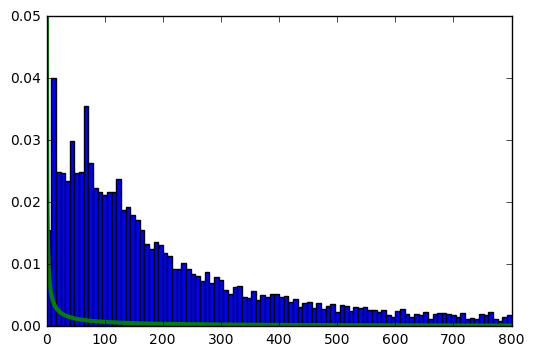

-82076.451605670722

In [12]:
x = hcc.sort()
plt.hist(hcc,100, weights = wght,range=(0, 800))
plt.plot(hcc,sts.gamma.pdf(hcc,aGA_MLE,scale=bGA_MLE),linewidth=3, color='g')
plt.xlim(0,800)
plt.ylim(0,0.05)
plt.show()

log_lik_GA(hcc,aGA_MLE,bGA_MLE)

In [13]:
# (c) - MLE Generalized Gamma

# Initial Parameters 

mGG_0 = 1
aGG_0 = aGA_MLE
bGG_0 = bGA_MLE

In [14]:
# Define the Log-Likelihood Function - Generalized Gamma

def log_lik_GG(xvect,alpha,beta,m):
    pdf_vect = sts.gengamma.pdf(xvect,alpha,m,scale=beta)
    ln_pdf_vect = np.log(pdf_vect)
    log_lik_scal = ln_pdf_vect.sum()
    return log_lik_scal

log_lik_GG(hcc,aGG_0,bGG_0,mGG_0)

-82076.451605670722

In [15]:
# Define Criterion Function - Generalized Gamma

def crit_GG(prms,*args):
    alpha , beta, m = prms
    xvals = args
    log_lik_scal = log_lik_GG(xvals,alpha,beta,m)
    neg_log_lik_scal = - log_lik_scal
    
    return neg_log_lik_scal

In [16]:
# Optimize  - Generalized Gamma

GGpar_vect = np.array([aGG_0,bGG_0,mGG_0])
mle_args = (hcc)
bnds_3 = ((0, None), (0, None),(0, None))
estimates = opt.minimize( crit_GG , GGpar_vect , args=mle_args , bounds=bnds_3)
aGG_MLE, bGG_MLE, mGG_MLE = estimates.x

print('alpha_MLE=',aGG_MLE,'beta_MLE=',bGG_MLE,'m_MLE=',mGG_MLE)


alpha_MLE= 0.222276681405 beta_MLE= 21911.064472 m_MLE= 0.997648161349


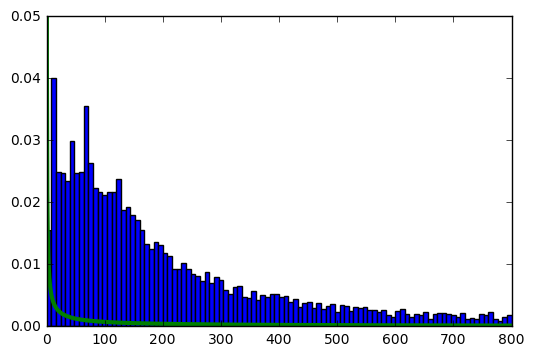

In [17]:
x = hcc.sort()
plt.hist(hcc,100, weights = wght,range=(0, 800))
plt.plot(hcc,sts.gengamma.pdf(hcc,aGG_MLE,mGG_MLE,scale=bGG_MLE),linewidth=3, color='g')
plt.xlim(0,800)
plt.ylim(0,0.05)
plt.show()


In [18]:
# (d) - MLE Generalized Beta 2

# Initial Parameters 


qGB2_0 = 10000
bGB2_0 = (qGB2_0**(1/mGG_MLE))*bGG_MLE
aGB2_0 = mGG_MLE
pGB2_0 = aGG_MLE/mGG_MLE

aGB2_0, bGB2_0, pGB2_0, qGB2_0


(0.99764816134947609, 223920063.2239196, 0.22280067263804348, 10000)

In [59]:
# Construct GB2 distribution from Beta Prime

def genbetaprime_pdf(xvect,a,b,p,q):
    #X = (xvect/q)**p
    #y = sts.betaprime.pdf(X, a, b)
    nom = p * ((xvect/q)**(a*p-1)) * (1+(xvect/q)**p)**(-a-b)
    den = q * special.beta(a,b)
    gb2_pdf = nom/den
    return gb2_pdf

# Build GB2 distribution using rv_continuous


from scipy.stats import rv_continuous

class GB2_gen(rv_continuous):
    def _pdf(self,x,a,b,p):
        nom = p * ((x)**(a*p-1)) * (1+(x)**p)**(-a-b)
        den = special.beta(a,b)
        gb2_pdf = nom/den
        return gb2_pdf

genbetaprim = GB2_gen(name='genbetaprim')
class_arg = (aGB2_0, bGB2_0, pGB2_0)
y = genbetaprim.pdf(np.linspace(0,800,100),aGB2_0, bGB2_0, pGB2_0,scale=qGB2_0)



array([ inf,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.])

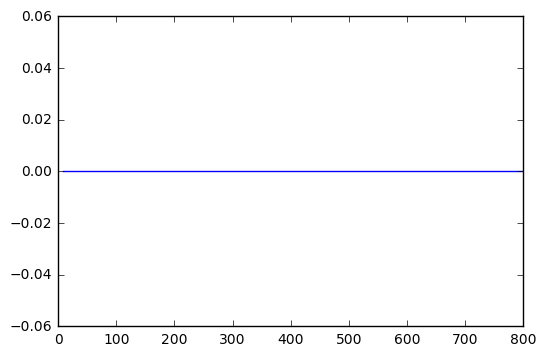

In [20]:
# Plot GB2 with initial guessess for a,b,p & q

test = genbetaprime_pdf(np.linspace(0,800,100),aGB2_0, bGB2_0, pGB2_0, qGB2_0)
test_2 = sts.betaprime.pdf(np.linspace(0,800,100),aGB2_0,bGB2_0,scale=10000)
test_3 = sts.gengamma.pdf(np.linspace(0,800,100),aGG_MLE,mGG_MLE,scale=bGG_MLE)

plt.plot(np.linspace(0,800,100),test)
#plt.plot(np.linspace(0,800,100),test_3)
plt.show()

In [60]:
# Define the Log-Likelihood Function - Generalized Beta 2

def log_lik_GB2(xvect,a,b,p,q):
    pdf_vect = genbetaprime_pdf(xvect,a,b,p,q)
    ln_pdf_vect = np.log(pdf_vect)
    log_lik_scal = ln_pdf_vect.sum()
    return log_lik_scal

log_lik_GB2(hcc,aGB2_0,bGB2_0,pGB2_0,qGB2_0)


-inf

In [28]:
# Define Criterion Function - Generalized Beta

def crit_GB2(prms,*args):
    a,b,p,q = prms
    xvals = args
    log_lik_scal = log_lik_GB2(xvals,a,b,p,q)
    neg_log_lik_scal = - log_lik_scal
    
    return neg_log_lik_scal

In [29]:
# Optimize  - Generalized Beta

GB2par_vect = np.array([aGB2_0,bGB2_0,pGB2_0,qGB2_0])
mle_args = (hcc)
bnds_4 = ((0, None), (0, None),(0, None),(0, None))
estimates = opt.minimize( crit_GB2 , GB2par_vect , args=mle_args , bounds=bnds_4)
aGB2_MLE,bGB2_MLE,pGB2_MLE,qGB2_MLE = estimates.x

print('a_MLE=',aGB2_MLE,'b_MLE=',bGB2_MLE,'p_MLE=',pGB2_MLE,'q_MLE=',qGB2_MLE)

a_MLE= 0.997648161349 b_MLE= 223920063.224 p_MLE= 0.222800672638 q_MLE= 10000.0


In [33]:
# (e) - Likelihood Ratio Test

    # Estimates from (b) and (d)
    
aGB_b = 1
bGB_b = 10000*bGA_MLE
pGB_b = aGA_MLE
qGB_b = 10000
    
h_0_b = log_lik_GB2(hcc,aGB_b,bGB_b,pGB_b,qGB_b)
log_lik_GB2(hcc,aGB2_0,bGB2_0,pGB2_0,qGB2_0)
    
    
    
    

In [32]:
    # Estimates from (c) and (d)
    
aGB_b = mGG_MLE
bGB_b = (10000**(1/mGG_MLE))*bGG_MLE
pGB_b = aGG_MLE
qGB_b = 10000


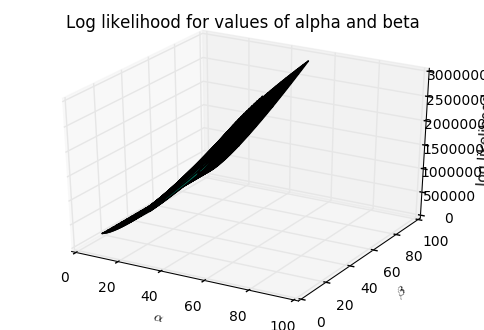

In [148]:
# Plot LogLikelihood Function

import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
cmap1 = matplotlib.cm.get_cmap('summer')

alph_vals = np.linspace(0,100,50)
beta_vals = np.linspace(0,2200,50)

lnlik_vals = np.zeros((50,50))

for a_i in range(50):
    for b_i in range(50):
        lnlik_vals[a_i,b_i] = -log_lik_GA(hcc,alph_vals[a_i],beta_vals[b_i])

alph_mesh, beta_mesh = np.meshgrid(alph_vals, alph_vals)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(beta_mesh, alph_mesh, lnlik_vals, rstride=8,
                cstride=1, cmap=cmap1)
ax.set_title('Log likelihood for values of alpha and beta')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
ax.set_zlabel(r'log likelihood')

plt.show()
